In [5]:
import pandas as pd
import seaborn as sns
import pybedtools as pbt
import sys
import matplotlib.pyplot as plt
import numpy as np
import itertools

## Prepare list of genes, adding promoters
To link SNPs, peaks, and loops to genes, we first need a list of genes and their coordinates. I'll download this from GENCODE as a GTF, then extract the necessary info and convert the coordinates to BED for use in intersection with pyBedTools

In [9]:
# Change the working directory to the data dir
%cd /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data

/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data


In [10]:
%pwd

'/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data'

In [4]:
# Download genome annotation and extract whole-gene records
! mkdir -p resources
! curl ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_33/gencode.v33.annotation.gtf.gz | \
    gunzip -c | awk '{OFS="\t"}{if ($3 == "gene"){print $0}}' > resources/gencode.v33.annotation.gtf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41.2M  100 41.2M    0     0  2847k      0  0:00:14  0:00:14 --:--:-- 6102k


In [12]:
a = pbt.BedTool("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/resources/gencode.v33.annotation.gtf").to_dataframe()
a.head()

,seqname,source,feature,start,end,score,strand,frame,attributes
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc..."
1,chr1,HAVANA,gene,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5""; gene_type ""unproc..."
2,chr1,ENSEMBL,gene,17369,17436,.,-,.,"gene_id ""ENSG00000278267.1""; gene_type ""miRNA""..."
3,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5""; gene_type ""lncRNA..."
4,chr1,ENSEMBL,gene,30366,30503,.,+,.,"gene_id ""ENSG00000284332.1""; gene_type ""miRNA""..."


In [13]:
attributes = a.attributes.str.split(';', expand=True).iloc[:,:3].apply(lambda x: x.str.split('"', expand=True)[1], axis=1)

In [14]:
attributes.columns = ['name_gene', 'gene_type', 'gene_symbol']
a = pd.concat([a.drop(columns='attributes'),attributes], axis=1)

In [16]:
a['start'] = a['start'] - 1 # Drop to 0-based index before converting to BED
pbt.BedTool().from_dataframe(a[['seqname', 'start', 'end', 'name_gene', 'score','strand']]).saveas('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/resources/gencodev33_ensembl_genes.bed')

<BedTool(/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/resources/gencodev33_ensembl_genes.bed)>

Make a table to later convert ENSID to gene symbol

In [17]:
conversion = a[['name_gene', 'gene_symbol', 'gene_type']]
conversion.head()

,name_gene,gene_symbol,gene_type
0,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene
1,ENSG00000227232.5,WASH7P,unprocessed_pseudogene
2,ENSG00000278267.1,MIR6859-1,miRNA
3,ENSG00000243485.5,MIR1302-2HG,lncRNA
4,ENSG00000284332.1,MIR1302-2,miRNA


In [19]:
genes_bed = pbt.BedTool("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/resources/gencodev33_ensembl_genes.bed").to_dataframe()

In [20]:
genes_bed.head()

,chrom,start,end,name,score,strand
0,chr1,11867,14409,ENSG00000223972.5,.,+
1,chr1,14402,29570,ENSG00000227232.5,.,-
2,chr1,17367,17436,ENSG00000278267.1,.,-
3,chr1,29552,31109,ENSG00000243485.5,.,+
4,chr1,30364,30503,ENSG00000284332.1,.,+


In [21]:
def addPromoter(x, length=1000):
    if x['strand'] == '+' and x['start'] > length:
        x['start'] -= length
    elif x['strand'] == '+' and x['start'] <= length:
        x['start'] = 0
    else:
        x['end'] += length
    return x

In [22]:
def extractPromoters(x, length=1000):
    if x['strand'] == '+' and x['start'] > length:
        x['end'] = x['start']
        x['start'] -= length
    elif x['strand'] == '+' and x['start'] <= length:
        x['end'] = x['start']
        x['start'] = 0
    else:
        x['start'] = x['end']
        x['end'] += length
    return x

In [23]:
genes_wpromoter = genes_bed.apply(addPromoter, axis=1)

In [24]:
genes_promoters = pbt.BedTool().from_dataframe(genes_wpromoter)

In [25]:
all_promoters = genes_bed.apply(extractPromoters, axis=1)

In [26]:
all_promoters = pbt.BedTool().from_dataframe(all_promoters)

In [27]:
genes_promoters.head()

chr1	10867	14409	ENSG00000223972.5	.	+
 chr1	14402	30570	ENSG00000227232.5	.	-
 chr1	17367	18436	ENSG00000278267.1	.	-
 chr1	28552	31109	ENSG00000243485.5	.	+
 chr1	29364	30503	ENSG00000284332.1	.	+
 chr1	34552	37081	ENSG00000237613.2	.	-
 chr1	51471	53312	ENSG00000268020.3	.	+
 chr1	56596	64116	ENSG00000240361.2	.	+
 chr1	64417	71585	ENSG00000186092.6	.	+
 chr1	89293	134723	ENSG00000238009.6	.	-
 

## How many Th1/17 ATAC peaks contain a GWAS SNP?

In [28]:
# %%bash
# # Convert merged ATAC SAF file to BED
# awk 'OFS="\t" {{print $2,$3-1,$4,$1,$5}}' ../atac-seq/200102_human_th1_th17_atac/peaks/combined_peaks_merged.saf > atac_snp_loop/combined_ATAC_peaks.bed

In [1]:
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ld_expansion/ensembl_ldlink_snps_r2_0.8.deduplicated.bed

88138 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed
10916 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ld_expansion/ensembl_ldlink_snps_r2_0.8.deduplicated.bed


In [29]:
# Load all ATAC peaks and GWAS LD-enhanced SNPs
atac = pbt.BedTool("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed")
gwas = pbt.BedTool("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ld_expansion/ensembl_ldlink_snps_r2_0.8.deduplicated.bed")

In [30]:
# Intersect ATAC peaks with GWAS SNPs
atac_gwas = atac.intersect(gwas, nonamecheck=True, loj=True).to_dataframe()
atac_gwas.columns = ['chrom_atac', 'start_atac', 'end_atac', 'name_atac', 'score', 
                     'chr_snp', 'start_snp', 'end_snp', 'name_snp']
atac_gwas = atac_gwas.replace([-1, "."], np.nan)

In [31]:
%%bash
mkdir -p /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/atac_snp_loop

In [32]:
pbt.BedTool().from_dataframe(atac_gwas).saveas("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/atac_snp_loop/ATAC_snp_overlap.bed")

<BedTool(/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/atac_snp_loop/ATAC_snp_overlap.bed)>

In [33]:
# Find which ATAC peaks overlap promoters
atac_promoter = atac.intersect(all_promoters, nonamecheck=True).to_dataframe()

In [34]:
# How many SNPs are in each ATAC peak?
atac_gwas.groupby('name_atac').count().sort_values('name_snp', ascending=False).head()

,chrom_atac,start_atac,end_atac,score,chr_snp,start_snp,end_snp,name_snp
name_atac,,,,,,,,
chr6.29942011.29943746,12,12,12,0,12,12,12,12
chr11.118699521.118700951,10,10,10,0,10,10,10,10
chr6.32609346.32610553,10,10,10,0,10,10,10,10
chr7.37365189.37366013,6,6,6,0,6,6,6,6
chr21.33403118.33404760,5,5,5,0,5,5,5,5


In [35]:
print("%.4f%% of ATAC peaks contain a GWAS SNP" % (sum(~atac_gwas.drop_duplicates('name_atac').name_snp.isna()) / len(atac_gwas.drop_duplicates('name_atac'))))

0.0061% of ATAC peaks contain a GWAS SNP


In [36]:
atac_gwas[~atac_gwas.name_snp.isna()].drop_duplicates(["name_atac", 'name_snp']).head()

,chrom_atac,start_atac,end_atac,name_atac,score,chr_snp,start_snp,end_snp,name_snp
140,chr1,2585245,2587484,chr1.2585246.2587484,NaN,chr1,2585382.0,2585391.0,rs554599679
141,chr1,2585245,2587484,chr1.2585246.2587484,NaN,chr1,2585341.0,2585342.0,rs60733400
142,chr1,2641984,2643716,chr1.2641985.2643716,NaN,chr1,2642638.0,2642639.0,rs9970196
144,chr1,2652606,2656303,chr1.2652607.2656303,NaN,chr1,2653604.0,2653605.0,rs6604990
145,chr1,2652606,2656303,chr1.2652607.2656303,NaN,chr1,2652812.0,2652813.0,rs4648665


In [37]:
# How many ATAC peaks contained GWAS SNPs?
sum(~atac_gwas.drop_duplicates('name_atac').name_snp.isna())

542

Out of the ~88k ATAC peaks, 542 have GWAS SNPs

## Find loop-mediated ATAC-gene interactions

In [27]:
%%bash
# Extract the loops from BEDPE to BED files with loop IDs

# awk 'OFS="\t" {print "chr"$1,$2,$3,"th17."NR-1"_left\nchr"$4,$5,$6,"th17."NR-1"_right"}' \
# ../190416_human_hic/th17/mega/aligned/loops_pw631/merged_loops_noheader.bedpe \
# > all_th17_anchors.bed

# awk 'OFS="\t" {print "chr"$1,$2,$3,"th1."NR-1"_left\nchr"$4,$5,$6,"th1."NR-1"_right"}' \
# ../190416_human_hic/th1/mega/aligned/loops_pw631/merged_loops_noheader.bedpe \
# > all_th1_anchors.bed

awk 'OFS="\t" {print $1,$2,$3,"loop."NR-1"_left\n"$4,$5,$6,"loop."NR-1"_right"}' \
"loops/merged_loops.bedpe" \
> "atac_snp_loop/all_anchors.bed"

In [28]:
# %%bash
# # Concatenate the loops from Th1 and Th17
# cat all_th17_anchors.bed all_th1_anchors.bed > all_anchors.bed

In [38]:
# Load the loops into python
# th17_anchor = pbt.BedTool("all_th17_anchors.bed")
# th1_anchor = pbt.BedTool("all_th1_anchors.bed")
all_anchor = pbt.BedTool("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/all_anchors.bed")
len(all_anchor)

32488

In [39]:
def reformatAnchorName(df):
    '''Takes the anchor name, creates a new column for left vs right ("anc_pos") and 
    moves the anchor ID to the index'''
    split_anchors = df.name_anc.str.split("_", expand=True)
    split_anchors.columns = ['name_anc', 'anc_pos']
    df = df.drop(columns='name_anc')
    df = pd.concat((df, split_anchors), axis=1)
    return df

In [40]:
# Intersect all anchors with combined ATAC peaks
anchor_atac = all_anchor.intersect(atac, loj=True, nonamecheck=True).to_dataframe()
anchor_atac.columns = ["chrom_anc", "start_anc", "end_anc", "name_anc", 
                               "chrom_atac", "start_atac","end_atac", "name_atac", "strand_atac"]
anchor_atac = reformatAnchorName(anchor_atac)
# Intersect all anchors with GENCODEv29 genes
anchor_gene = all_anchor.intersect(genes_promoters, loj=True, nonamecheck=True).to_dataframe()
anchor_gene.columns = ["chrom_anc", "start_anc", "end_anc", "name_anc", 
                               "chrom_gene", "start_gene","end_gene", "name_gene", "score_gene", "strand_gene"]
anchor_gene = reformatAnchorName(anchor_gene)
print("%d anchor-ATAC interactions" % len(anchor_atac))
print("%d anchor-gene interaction" % len(anchor_gene))

65696 anchor-ATAC interactions
55944 anchor-gene interaction


In [41]:
# Join the genes and atac
anchor_atac_gene = pd.merge(anchor_atac, anchor_gene, on='name_anc', suffixes=('_at','_ge'), how='left')
anchor_atac_gene.head()
# Drop useless / redundant columns
# anchor_atac_gene.drop(columns=['chrom_anc_ge', 'start_anc_ge', 'end_anc_ge','strand_atac'], inplace=True)
anchor_atac_gene.drop(columns=['strand_atac', 'score_gene'], inplace=True)
len(anchor_atac_gene)

247128

In [42]:
anchor_atac_gene = anchor_atac_gene.replace([-1, "."], np.nan)

In [43]:
anchor_atac_gene.head()

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,start_anc_ge,end_anc_ge,chrom_gene,start_gene,end_gene,name_gene,strand_gene,anc_pos_ge
0,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,980000,990000,chr1,975202.0,983093.0,ENSG00000187642.9,-,left
1,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,1060000,1070000,chr1,1062206.0,1064288.0,ENSG00000273443.1,-,right
2,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,1060000,1070000,chr1,1058706.0,1069355.0,ENSG00000217801.10,+,right
3,chr1,980000,990000,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,980000,990000,chr1,975202.0,983093.0,ENSG00000187642.9,-,left
4,chr1,980000,990000,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,1060000,1070000,chr1,1062206.0,1064288.0,ENSG00000273443.1,-,right


In [44]:
# Filter for rows where the ATAC peak and gene are on opposite sides of the loop
# Also filter out rows that have no ATAC peak
loop_mediated = anchor_atac_gene[(anchor_atac_gene.anc_pos_at != anchor_atac_gene.anc_pos_ge) & (~anchor_atac_gene.name_atac.isna())]
print("Identified %d looping interactions involving ATAC peaks" % len(loop_mediated))
print("%d of these link ATAC peaks to genes" % len(loop_mediated[~loop_mediated.name_gene.isna()]))

Identified 116068 looping interactions involving ATAC peaks
109579 of these link ATAC peaks to genes


### Merge GWAS SNPs using ATAC IDs

In [45]:
# Use the ATAC peak IDs to join the GWAS SNP IDs to the data
loop_mediated_snp = pd.merge(loop_mediated, atac_gwas, on='name_atac', how='left', suffixes=('', '_gw'))

In [46]:
# Remove redundant columns (everything tagged with "gw")
loop_mediated_snp = loop_mediated_snp.drop(columns=loop_mediated_snp.columns[['gw' in x for x in loop_mediated_snp.columns]])

In [47]:
# How does adding GWAS SNPs make the list longer? Answer: ATAC peaks with multiple SNPs.
print(len(loop_mediated))
print(len(loop_mediated_snp))

116068
116925


In [48]:
# How many of these interactions have SNPs?
print("There are {} loop_mediated interactions involving a SNP".format(len(loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].drop_duplicates())))

There are 1991 loop_mediated interactions involving a SNP


In [49]:
# How many of the interactions above link to a gene?
print(len(loop_mediated_snp[(~loop_mediated_snp.name_snp.isna()) & (~loop_mediated_snp.name_gene.isna())].drop_duplicates()))

1883


In [50]:
# Export table of ATAC+SNP to gene interactions
loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].drop_duplicates().to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/atac_snp_loop/ATAC_snp_gene_interactions.tab", sep="\t", index=None)

## Incorporate non-looped ATAC-SNP-gene info

In [51]:
# This is a true intersection, only ATAC peaks that overlap genes+promoters are returned
atac_gene = atac.intersect(genes_promoters, wo=True, nonamecheck=True).to_dataframe()
atac_gene.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,chr1,9939,11526,chr1.9940.11526,.,chr1,10867,14409,ENSG00000223972.5,.,+,659
1,chr1,28527,30143,chr1.28528.30143,.,chr1,28552,31109,ENSG00000243485.5,.,+,1591
2,chr1,28527,30143,chr1.28528.30143,.,chr1,29364,30503,ENSG00000284332.1,.,+,779
3,chr1,28527,30143,chr1.28528.30143,.,chr1,14402,30570,ENSG00000227232.5,.,-,1616
4,chr1,91075,91593,chr1.91076.91593,.,chr1,89549,92105,ENSG00000239945.1,.,-,518


In [52]:
# Reformat dataframe
atac_gene.drop(columns=['score', 'blockStarts'], inplace=True)
atac_gene.columns = ['chrom_atac', 'start_atac', 'end_atac', 'name_atac', 
                     'chrom_gene', 'start_gene', 'end_gene', 'name_gene', 'score_gene', 'strand_gene']

In [53]:
# Merge atac-gwas overlaps using the atac ID
atac_gene_gwas = pd.merge(atac_gene, atac_gwas, on='name_atac', how='left', suffixes=('', '_gw'))
# Remove redudnant columns
atac_gene_gwas = atac_gene_gwas.drop(columns=atac_gene_gwas.columns[['gw' in x for x in atac_gene_gwas.columns]])
# Save as table
atac_gene_gwas.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/atac_snp_loop/atac_gene_gwas_direct.tab", sep="\t", index=None)

In [54]:
atac_gene_gwas.dropna(subset=['name_snp']).head()

,chrom_atac,start_atac,end_atac,name_atac,chrom_gene,start_gene,end_gene,name_gene,score_gene,strand_gene,score,chr_snp,start_snp,end_snp,name_snp
169,chr1,2585245,2587484,chr1.2585246.2587484,chr1,2585489,2591469,ENSG00000157870.16,.,+,NaN,chr1,2585382.0,2585391.0,rs554599679
170,chr1,2585245,2587484,chr1.2585246.2587484,chr1,2585489,2591469,ENSG00000157870.16,.,+,NaN,chr1,2585341.0,2585342.0,rs60733400
171,chr1,2641984,2643716,chr1.2641985.2643716,chr1,2635974,2802717,ENSG00000215912.12,.,-,NaN,chr1,2642638.0,2642639.0,rs9970196
173,chr1,2652606,2656303,chr1.2652607.2656303,chr1,2635974,2802717,ENSG00000215912.12,.,-,NaN,chr1,2653604.0,2653605.0,rs6604990
174,chr1,2652606,2656303,chr1.2652607.2656303,chr1,2635974,2802717,ENSG00000215912.12,.,-,NaN,chr1,2652812.0,2652813.0,rs4648665


In [55]:
all_interactions = pd.concat([loop_mediated_snp, atac_gene_gwas], sort=False)

In [56]:
all_interactions = all_interactions.replace([-1,'.'], np.nan).drop_duplicates()
all_interactions.shape

(199489, 24)

In [57]:
# Add gene names using ensembl IDs
all_interactions = pd.merge(all_interactions, conversion, on='name_gene', how="left")
all_interactions.shape

(199489, 26)

In [58]:
all_interactions.gene_symbol.sort_values()

156569           A1BG
156570       A1BG-AS1
132976        A2M-AS1
132960          A2ML1
23008           A2ML1
132957      A2ML1-AS1
132959      A2ML1-AS1
132979          A2MP1
132983          A2MP1
167833         A4GALT
134226           AAAS
134227           AAAS
136511           AACS
136512           AACS
80233           AADAC
80237           AADAC
80362           AADAC
80231           AADAC
80360           AADAC
80235           AADAC
80232     AADACL2-AS1
80234     AADACL2-AS1
80236     AADACL2-AS1
80238     AADACL2-AS1
80361     AADACL2-AS1
80363     AADACL2-AS1
172388    AADACL2-AS1
172386    AADACL2-AS1
172389    AADACL2-AS1
172387    AADACL2-AS1
             ...     
116258            NaN
116259            NaN
116260            NaN
116261            NaN
116262            NaN
116264            NaN
116265            NaN
116270            NaN
116323            NaN
116326            NaN
116328            NaN
116444            NaN
116445            NaN
116446            NaN
116474    

In [59]:
all_interactions['atac_promoter'] = all_interactions.name_atac.isin(atac_promoter.name)

In [60]:
# Drop any row that doesn't link to a gene
# all_interactions = all_interactions.dropna(subset=['name_gene'])

In [61]:
all_interactions.shape

(199489, 27)

In [62]:
genes_snp_in_promoter = set(all_interactions[(all_interactions.atac_promoter) & (~all_interactions.name_snp.isna())].gene_symbol.dropna())

## Useful stats

In [63]:
print("%d loop-mediated interactions" % len(all_interactions[~all_interactions.anc_pos_at.isin([np.nan])]))
print("%d direct interaction" % len(all_interactions[all_interactions.anc_pos_at.isin([np.nan])]))
print("%d total interactions" % len(all_interactions))

116925 loop-mediated interactions
82564 direct interaction
199489 total interactions


In [64]:
# Involving a SNP?
print("%d SNPs participate in loop-mediated interactions" % 
      len(all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()))
print("%d loop-mediated interactions with SNPs" % 
      len(all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())]))
print("%d SNPs participate in direct interactions" % 
      len(all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()))
print("%d direct interaction with SNPs" % 
      len(all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())]))
print("%d total interactions" % 
      len(all_interactions[~all_interactions.name_snp.isna()].drop_duplicates(['name_atac', 'name_snp'])))

464 SNPs participate in loop-mediated interactions
1991 loop-mediated interactions with SNPs
700 SNPs participate in direct interactions
901 direct interaction with SNPs
816 total interactions


In [65]:
# How many of the unique SNPs from loop-mediated vs direct interactions are overlapping? 
# I.e. what is the intersection of the two sets of SNP IDs?
loop_uniq_snpid = all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()
direct_uniq_snpid = all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()
print("%d SNPs have looped and/or direct interactions" % len(np.union1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have both looped and direct interactions" % len(np.intersect1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have ONLY looped interactions" % len(np.setdiff1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have ONLY direct interactions" % len(np.setdiff1d(direct_uniq_snpid, loop_uniq_snpid)))

816 SNPs have looped and/or direct interactions
348 SNPs have both looped and direct interactions
116 SNPs have ONLY looped interactions
352 SNPs have ONLY direct interactions


In [66]:
genes_direct = atac_gene_gwas[~atac_gene_gwas.name_snp.isna()].name_gene.dropna().unique()
genes_indirect = loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].name_gene.dropna().unique()

In [67]:
# This is a way to quickly convert "." and -1 (null) values in a df to NaN
loop_mediated_snp.mask(loop_mediated_snp.isin([".", -1])).head()

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,...,start_gene,end_gene,name_gene,strand_gene,anc_pos_ge,score,chr_snp,start_snp,end_snp,name_snp
0,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,...,1062206.0,1064288.0,ENSG00000273443.1,-,right,NaN,NaN,NaN,NaN,NaN
1,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,...,1058706.0,1069355.0,ENSG00000217801.10,+,right,NaN,NaN,NaN,NaN,NaN
2,chr1,980000,990000,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,...,1062206.0,1064288.0,ENSG00000273443.1,-,right,NaN,NaN,NaN,NaN,NaN
3,chr1,980000,990000,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,...,1058706.0,1069355.0,ENSG00000217801.10,+,right,NaN,NaN,NaN,NaN,NaN
4,chr1,1060000,1070000,chr1,1058908.0,1060229.0,chr1.1058909.1060229,loop.0,right,chr1,...,975202.0,983093.0,ENSG00000187642.9,-,left,NaN,NaN,NaN,NaN,NaN


In [69]:
# Annotate lead SNPs
# lead_snps = pd.read_table("../GWAS_snps/query_gwas_snps_hg38.bed", header=None)
lead_snps = pd.read_table("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ld_expansion/ensembl_ldlink_final_snp_info.tab")
all_interactions['is_lead_snp'] = all_interactions.name_snp.isin(lead_snps['query'])
all_interactions[all_interactions.is_lead_snp]
# Add column indicating whether interaction is looped or not
all_interactions['is_looped'] = ~all_interactions.name_anc.isna()

In [70]:
print("A total of {} lead SNPs were used from the EBI GWAS catalog and MS Genomic Map".format(lead_snps.drop_duplicates('query').shape[0]))
print("These SNPs were used to query the LD data from the 1000 Genomes project, \
resulting in a total of {} SNPs identified within R2>=0.8 of a GWAS lead SNP".format(lead_snps.drop_duplicates('result').shape[0]))

A total of 597 lead SNPs were used from the EBI GWAS catalog and MS Genomic Map
These SNPs were used to query the LD data from the 1000 Genomes project, resulting in a total of 10921 SNPs identified within R2>=0.8 of a GWAS lead SNP


In [71]:
print("Among the SNP catalog identified, {} overlapped a Th-cell ATAC peak (Th1 or Th17).".format(len(all_interactions.name_snp.dropna().unique())))

Among the SNP catalog identified, 816 overlapped a Th-cell ATAC peak (Th1 or Th17).


In [72]:
print("We identified {} looped interactions involving an ATAC peak, SNP, and gene.".format(sum(all_interactions[(~all_interactions.name_snp.isna()) & (~all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_gene', 'name_snp']).is_looped)))
print("We also identified {} non-looped interactions involving a SNP within an ATAC peak located within a gene or promoter.".format(sum(~all_interactions[(~all_interactions.name_snp.isna()) & (~all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_gene', 'name_snp']).is_looped)))
print("{} SNPs associated with ATAC and/or loop but did not associate with a gene".format(len(all_interactions[(~all_interactions.name_snp.isna()) & (all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_snp']))))

We identified 1797 looped interactions involving an ATAC peak, SNP, and gene.
We also identified 848 non-looped interactions involving a SNP within an ATAC peak located within a gene or promoter.
87 SNPs associated with ATAC and/or loop but did not associate with a gene


In [73]:
looped_genes = set(all_interactions.loc[(~all_interactions.name_snp.isna()) & (all_interactions.is_looped) & (~all_interactions.name_gene.isna()),'gene_symbol'])
print("For looped interactions, there were {} unique genes associated with SNPs".format(len(looped_genes)))
non_looped_genes = set(all_interactions.loc[(~all_interactions.name_snp.isna()) & (~all_interactions.is_looped) & (~all_interactions.name_gene.isna()),'gene_symbol'])
print("For non-looped interactions, there were {} unique genes associated with SNPs".format(len(non_looped_genes)))
print("There were {} genes shared betweent these".format(len(looped_genes.intersection(non_looped_genes))))

For looped interactions, there were 634 unique genes associated with SNPs
For non-looped interactions, there were 356 unique genes associated with SNPs
There were 71 genes shared betweent these


In [74]:
our_genes = set(all_interactions[~all_interactions.name_snp.isna()].gene_symbol.dropna().unique())

In [149]:
gwas_target = pd.read_excel("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/source_snps/aav7188_Patsopoulos_Tables S11-S20.xlsx", sheet_name="ST19", skiprows=3, header=[0,1])

In [150]:
# Take only the columns with r2 >= 0.8

gwas_target = gwas_target.drop(columns=[('Exonic genes', 'r2 >= 0.1'),
                                        ('Exonic genes', 'r2>=0.5'),
                          ('Intronic genes',  'r2 >= 0.1'),
                          ('Intronic genes', 'r2>=0.5'),
                         ('eQTL genes in the tested data sets',  'r2 >= 0.1'),
            ('eQTL genes in the tested data sets',    'r2>=0.5')])

gwas_target.columns = [".".join(pair) for pair in gwas_target.columns]
gwas_target = gwas_target.rename(columns={'Unnamed: 0_level_0.Step':'Step',
                                          'Unnamed: 1_level_0.Effect':'Effect',
                                          'Unnamed: 2_level_0.Chromosome':'Chromosome',
                                          'Unnamed: 3_level_0.Position':'Position',
                                          'Unnamed: 4_level_0.A1':'A1',
                                          'Unnamed: 5_level_0.A2':'A2',
                                          'Exonic genes.r2>=0.8':'Exon',
                                          'Intronic genes.r2>=0.8':'Intron',
                                          'eQTL genes in the tested data sets.r2>=0.8':'eQTL'})


In [151]:
gwas_target.head()

,Step,Effect,Chromosome,Position,A1,A2,Exon,Intron,eQTL
Region101:rs2269434,0,rs2269434,11,47360412,T,C,ACP2|MADD|MYBPC3,MYBPC3|NR1H3|MADD|LOC101928943|MADD|MYBPC3,ACP2|DDB2|MADD|NR1H3|MTCH2
Region107:rs8062446,0,rs8062446,16,57077094,T,C,NaN,NLRC5,NaN
Region10:rs6670198,0,rs6670198,1,2520527,C,T,MMEL1,FAM213B|LOC115110|LOC100996583|MMEL1|TTC34,MMEL1|TNFRSF14|TTC34
Region110:rs9900529,0,rs9900529,17,73335776,C,G,NaN,GRB2,MRPS7|NUP85
Region111:rs2084007,0,rs2084007,5,133891282,C,T,NaN,JADE2,JADE2


In [152]:
# Add the SNP ID to the gene name
gwas_target['gene_with_snp'] = gwas_target.Exon.astype(str) + '|' + gwas_target.Intron.astype(str) + '|' + gwas_target.eQTL.astype(str)

In [154]:
gwas_target_with_snp = set(np.concatenate(gwas_target.dropna(subset=['gene_with_snp']).\
               apply(lambda x: [x['Effect'] + '-' + y for y in str(x['gene_with_snp']).\
                                split('|') if y != "nan"], axis=1).tolist()))

In [155]:
gwas_target.head()

,Step,Effect,Chromosome,Position,A1,A2,Exon,Intron,eQTL,gene_with_snp
Region101:rs2269434,0,rs2269434,11,47360412,T,C,ACP2|MADD|MYBPC3,MYBPC3|NR1H3|MADD|LOC101928943|MADD|MYBPC3,ACP2|DDB2|MADD|NR1H3|MTCH2,ACP2|MADD|MYBPC3|MYBPC3|NR1H3|MADD|LOC10192894...
Region107:rs8062446,0,rs8062446,16,57077094,T,C,NaN,NLRC5,NaN,nan|NLRC5|nan
Region10:rs6670198,0,rs6670198,1,2520527,C,T,MMEL1,FAM213B|LOC115110|LOC100996583|MMEL1|TTC34,MMEL1|TNFRSF14|TTC34,MMEL1|FAM213B|LOC115110|LOC100996583|MMEL1|TTC...
Region110:rs9900529,0,rs9900529,17,73335776,C,G,NaN,GRB2,MRPS7|NUP85,nan|GRB2|MRPS7|NUP85
Region111:rs2084007,0,rs2084007,5,133891282,C,T,NaN,JADE2,JADE2,nan|JADE2|JADE2


In [156]:
len(gwas_target_with_snp)

285

In [158]:
# Extract all the genes
gwas_target_genes = gwas_target.Intron.dropna().tolist() + gwas_target.dropna().eQTL.tolist()

In [159]:
gwas_target_genes = set(np.concatenate([str(x).split('|') for x in gwas_target_genes]))

In [160]:
len(gwas_target_with_snp)

285

In [161]:
aiws = all_interactions[(all_interactions.name_snp != ".") & (all_interactions.gene_symbol != ".")]

In [162]:
our_target_with_snp = set(aiws[['name_snp', 'gene_symbol']].dropna().apply(lambda x: x['name_snp'] + '-' + x['gene_symbol'], axis=1))

## How does our method compare to previous studies associating MS risk genes with SNPs?

In [163]:
from matplotlib_venn import venn3, venn2

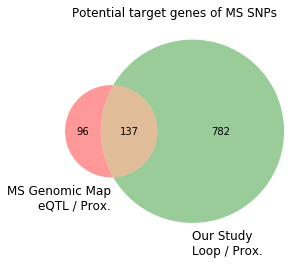

In [164]:
venn2((gwas_target_genes, our_genes), set_labels=("MS Genomic Map\neQTL / Prox.", "Our Study\nLoop / Prox."))
plt.title("Potential target genes of MS SNPs")
plt.show()

{'rs10271373-ZC3HAV1',
 'rs10951154-HOXA1',
 'rs1465697-CD37',
 'rs1738074-TAGAP',
 'rs2084007-JADE2',
 'rs2248137-CYP24A1',
 'rs244656-TCF7',
 'rs2469434-CD226',
 'rs32658-TNFAIP8',
 'rs3809627-TBX6',
 'rs4796224-ZNHIT3',
 'rs4812772-TOX2',
 'rs55858457-CHST12',
 'rs60600003-ELMO1',
 'rs67111717-RGS14',
 'rs7731626-ANKRD55',
 'rs883871-NR1D1',
 'rs9591325-DLEU1',
 'rs9900529-GRB2',
 'rs9909593-IKZF3'}

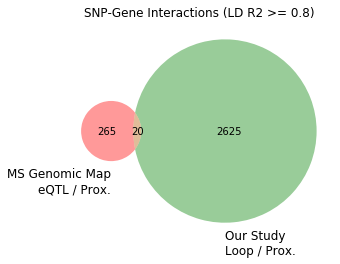

In [165]:
venn2((gwas_target_with_snp, our_target_with_snp), set_labels=("MS Genomic Map\neQTL / Prox.", "Our Study\nLoop / Prox."))
plt.title("SNP-Gene Interactions (LD R2 >= 0.8)")
gwas_target_with_snp.intersection(our_target_with_snp) # Common SNP-GENE pairings

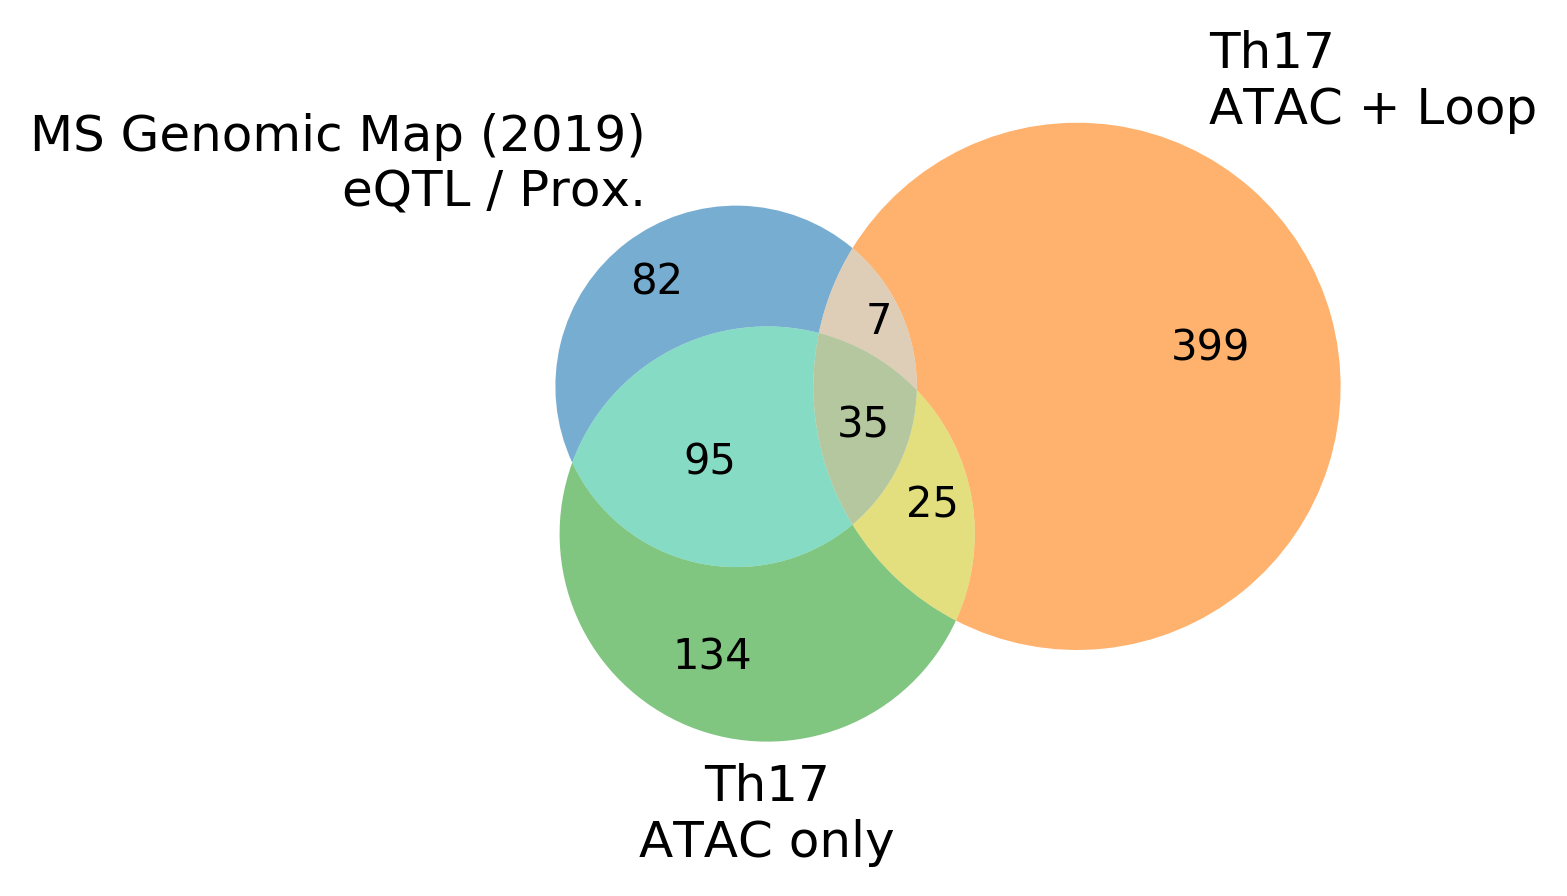

In [166]:
f, ax = plt.subplots(1,1,figsize=(5,5), dpi=300)
venn3(({x for x in gwas_target_genes if 'LOC' not in x}, #Remove all the weird genes (pseudogenes or other)
       {x for x in looped_genes if '.' not in x},
      {x for x in non_looped_genes if '.' not in x}),
     set_labels=("MS Genomic Map (2019)\neQTL / Prox.", "Th17\nATAC + Loop", "Th17\nATAC only"), 
      set_colors=sns.palettes.color_palette()[:3], alpha=0.6, ax=ax)
# ax.set_title("Genes Targeted by >= 1 SNP", pad=20, size=20)
f.tight_layout()

Ok , so incorporating looping identifies novel target genes. Which are they? Do we have some examples of obvious importance?

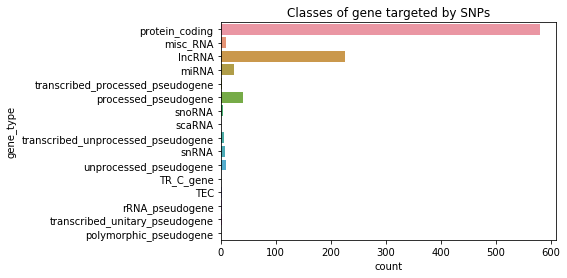

In [167]:
sns.countplot(data=all_interactions[~all_interactions.name_snp.isna()].drop_duplicates(["name_gene"]), y="gene_type")
plt.title("Classes of gene targeted by SNPs")
plt.show()

In [168]:
len(non_looped_genes - gwas_target_genes - genes_snp_in_promoter)

91

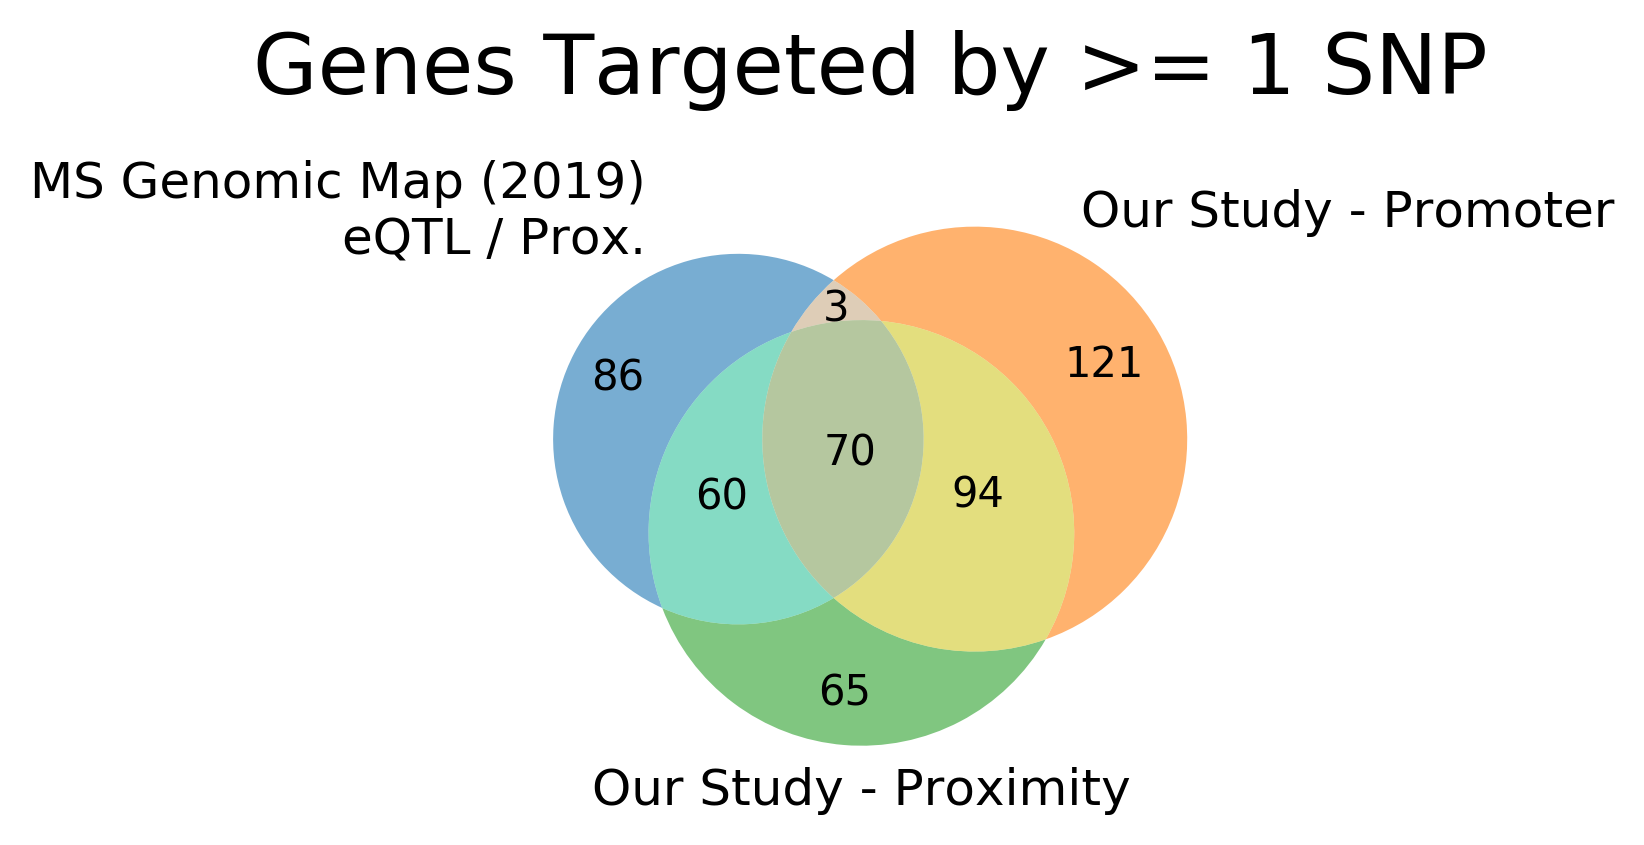

In [169]:
# How many of our unique targets are due to including promoters?
f, ax = plt.subplots(1,1,figsize=(5,5), dpi=300)
venn3(({x for x in gwas_target_genes if 'LOC' not in x}, #Remove all the weird genes (pseudogenes or other)
       {x for x in genes_snp_in_promoter if '.' not in x},
      {x for x in non_looped_genes if '.' not in x}),
     set_labels=("MS Genomic Map (2019)\neQTL / Prox.", "Our Study - Promoter", "Our Study - Proximity"), 
      set_colors=sns.palettes.color_palette()[:3], alpha=0.6, ax=ax)
ax.set_title("Genes Targeted by >= 1 SNP", pad=20, size=20)
f.tight_layout()

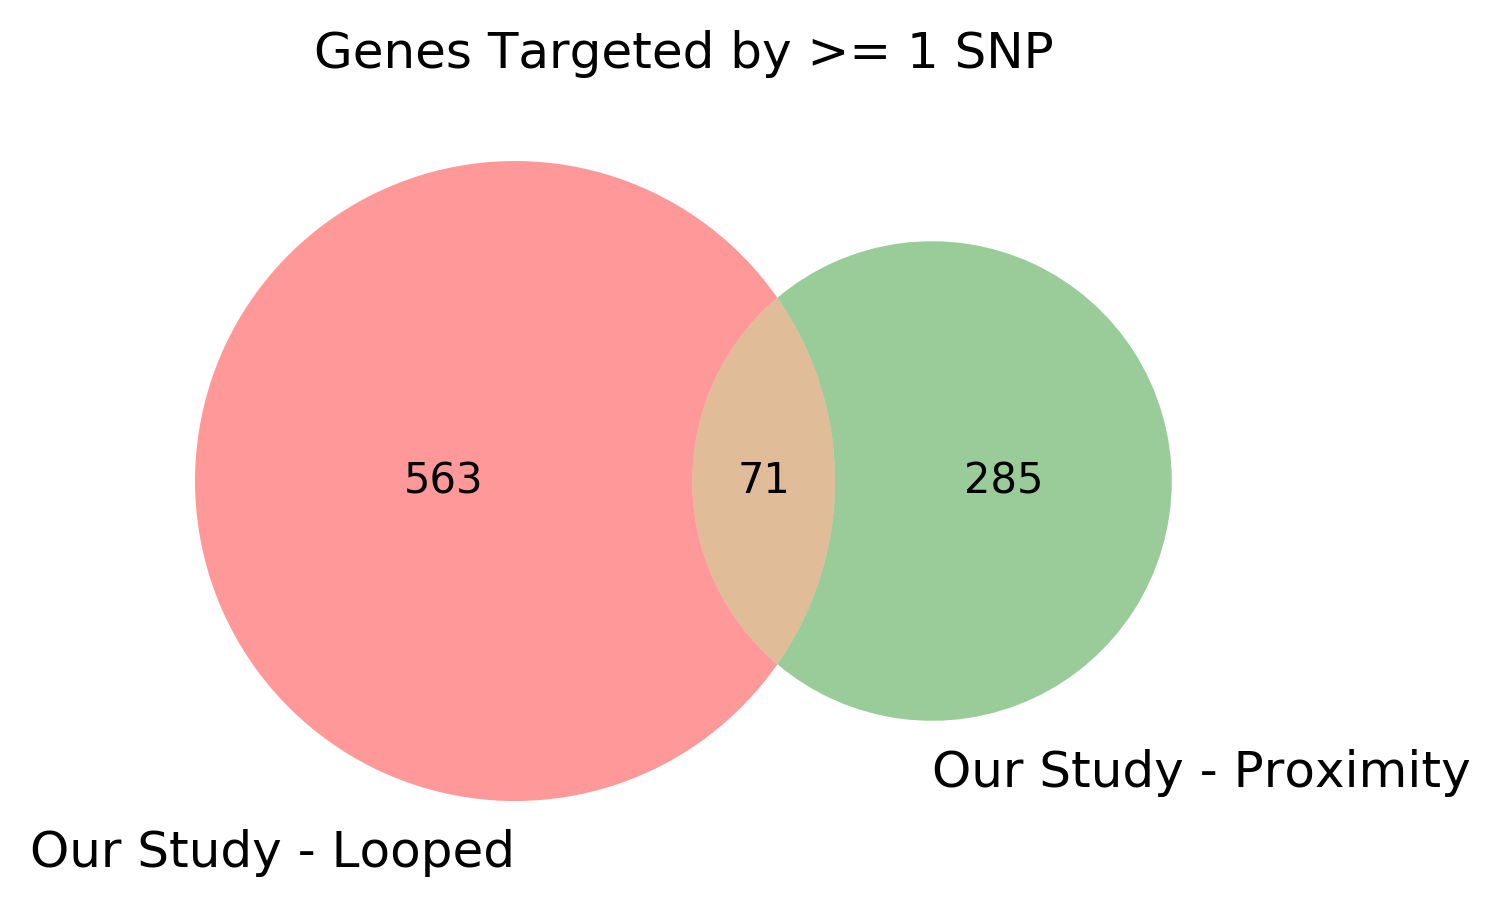

In [170]:
f, ax = plt.subplots(1,1,figsize=(5,5), dpi=300)
venn2((looped_genes, non_looped_genes), 
      set_labels=("Our Study - Looped", "Our Study - Proximity"), ax=ax)
ax.set_title("Genes Targeted by >= 1 SNP")
f.tight_layout()
# f.savefig("gene_overlap.svg")

In [171]:
(looped_genes-non_looped_genes).intersection(gwas_target_genes)

{'CLEC2D', 'CTSW', 'MANBA', 'PARP10', 'PLCG1', 'RASGRF1', 'SLC9B2'}

In [172]:
len(our_genes - gwas_target_genes)

782

In [173]:
all_interactions[(all_interactions.name_snp != ".") & (all_interactions.name_gene == ".")]

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,...,chr_snp,start_snp,end_snp,name_snp,score_gene,gene_symbol,gene_type,atac_promoter,is_lead_snp,is_looped


# Load RPKM data

In [175]:
th_rpkm = pd.read_table("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/rna-seq/190311_human_th_rnaseq/rpkm_bygroup.tab")
th_rpkm.drop(columns=['Geneid', 'Length'], inplace=True)
th_rpkm = th_rpkm.dropna(subset=["gene_symbol"])

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


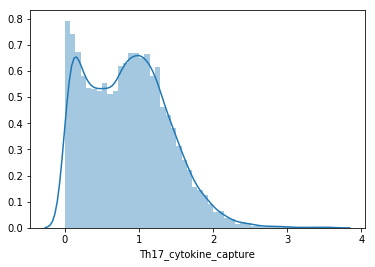

In [176]:
sns.distplot(np.log10(th_rpkm.Th17_cytokine_capture+1))

In [177]:
all_interactions_rpkm = pd.merge(all_interactions, th_rpkm, on='gene_symbol', how='left')

In [178]:
all_interactions_rpkm.head()

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,...,gene_symbol,gene_type,atac_promoter,is_lead_snp,is_looped,description,Th1_cytokine_capture,Th1_standard,Th17_cytokine_capture,Th17_standard
0,chr1,980000.0,990000.0,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,...,AL645608.8,lncRNA,False,False,True,NaN,NaN,NaN,NaN,NaN
1,chr1,980000.0,990000.0,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,...,AL390719.1,transcribed_unprocessed_pseudogene,False,False,True,NaN,1.070383,3.702225,1.389806,2.604054
2,chr1,980000.0,990000.0,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,...,AL645608.8,lncRNA,False,False,True,NaN,NaN,NaN,NaN,NaN
3,chr1,980000.0,990000.0,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,...,AL390719.1,transcribed_unprocessed_pseudogene,False,False,True,NaN,1.070383,3.702225,1.389806,2.604054
4,chr1,1060000.0,1070000.0,chr1,1058908.0,1060229.0,chr1.1058909.1060229,loop.0,right,chr1,...,PERM1,protein_coding,True,False,True,NaN,NaN,NaN,NaN,NaN


In [179]:
all_interactions_rpkm[all_interactions_rpkm.name_snp != "."].sort_values('Th17_standard', ascending=False).head()

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,...,gene_symbol,gene_type,atac_promoter,is_lead_snp,is_looped,description,Th1_cytokine_capture,Th1_standard,Th17_cytokine_capture,Th17_standard
59980,chr2,54550000.0,54575000.0,chr2,54572751.0,54573226.0,chr2.54572752.54573226,loop.8100,left,chr2,...,TMSB10,protein_coding,False,False,True,thymosin beta 10 [Source:HGNC Symbol;Acc:HGNC:...,3782.431379,2826.485163,3673.277916,2992.944251
59988,chr2,54550000.0,54575000.0,chr2,54574123.0,54575284.0,chr2.54574124.54575284,loop.8100,left,chr2,...,TMSB10,protein_coding,False,False,True,thymosin beta 10 [Source:HGNC Symbol;Acc:HGNC:...,3782.431379,2826.485163,3673.277916,2992.944251
60845,chr2,95050000.0,95075000.0,chr2,95055581.0,95057527.0,chr2.95055582.95057527,loop.8241,right,chr2,...,TMSB10,protein_coding,False,False,True,thymosin beta 10 [Source:HGNC Symbol;Acc:HGNC:...,3782.431379,2826.485163,3673.277916,2992.944251
158996,NaN,NaN,NaN,chr2,84905099.0,84906399.0,chr2.84905100.84906399,NaN,NaN,NaN,...,TMSB10,protein_coding,True,False,False,thymosin beta 10 [Source:HGNC Symbol;Acc:HGNC:...,3782.431379,2826.485163,3673.277916,2992.944251
60851,chr2,95050000.0,95075000.0,chr2,95073914.0,95075363.0,chr2.95073915.95075363,loop.8241,right,chr2,...,TMSB10,protein_coding,False,False,True,thymosin beta 10 [Source:HGNC Symbol;Acc:HGNC:...,3782.431379,2826.485163,3673.277916,2992.944251


In [181]:
# Load MS DE data
ms_de = pd.read_table("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/results/rna-seq/de_tables/MSvControl.tab")
ms_de.drop(columns=['ENSEMBL_ID', 'logCPM', 'Description'], inplace=True)
ms_de.columns = ['gene_symbol', 'logFC_MSvControl', 'PVal_MSvControl', 'FDR_MSvControl']
ms_de = ms_de.dropna().drop_duplicates(subset=['gene_symbol'])

In [182]:
ms_de.head()

,gene_symbol,logFC_MSvControl,PVal_MSvControl,FDR_MSvControl
0,CTSH,-1.328381,3.526299e-15,4.731941e-11
1,MIR3142HG,1.380565,7.290400e-14,4.891494e-10
2,PRR5,-1.101990,2.602947e-13,1.164298e-09
3,ALOX5,-1.499499,1.896985e-12,6.363910e-09
4,FUT7,-1.230372,1.379756e-09,3.702989e-06


In [183]:
ms_de[ms_de.duplicated("gene_symbol")]

,gene_symbol,logFC_MSvControl,PVal_MSvControl,FDR_MSvControl


In [185]:
# Integrate MS DE with looping
all_interactions_rpkm_de = pd.merge(all_interactions_rpkm, ms_de, on='gene_symbol', how='left')
all_interactions_rpkm_de.to_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/atac_snp_loop/all_interactions_rpkm_de.tab', sep="\t", index=None)
all_interactions_rpkm_de.dropna(subset=['name_snp']).to_csv('all_interactions_with_snp.tab', sep="\t", index=None)

In [186]:
all_interactions_rpkm.name_snp.dropna()

117       rs554599679
118        rs60733400
544        rs11576384
545        rs34918542
546        rs11576384
547        rs34918542
548        rs11576384
549        rs34918542
550        rs11576384
551        rs34918542
559        rs11576384
560        rs34918542
719        rs10914539
720        rs10914539
1226       rs10914539
1227       rs10914539
1228       rs10914539
1229       rs10914539
1230       rs10914539
1231       rs10914539
1318        rs7536201
1319        rs4265380
1320       rs11249212
1321       rs11249213
1322        rs7414934
1323        rs7536201
1324        rs4265380
1325       rs11249212
1326       rs11249213
1327        rs7414934
             ...     
193853     rs80150151
193854     rs80150151
193855     rs79140028
193922      rs2703000
193923      rs2703000
193924      rs2703000
194170     rs62522555
194171     rs11993233
194172     rs72693398
194173     rs11782331
194174     rs11783799
194175      rs6989119
194176     rs11136337
194177     rs11783772
194178    

Josh: There are a total of 155 unique (non-overlapping) anchors that contain ATAC peaks with GWAS-SNPs

## What is the typical distance from a loop anchor to the nearest ATAC peak?

In [187]:
l_centroids = all_anchor.to_dataframe().iloc[:,0:3]
l_centroids['cent_start'] = (l_centroids.start + ((l_centroids.end - l_centroids.start) / 2)).astype(int)
l_centroids['cent_end'] = l_centroids.cent_start + 1
z = pbt.BedTool().from_dataframe(l_centroids.drop(columns=['start', 'end']))

In [188]:
dist_l = z.sort().closest(atac, nonamecheck=True, D='ref').to_dataframe()

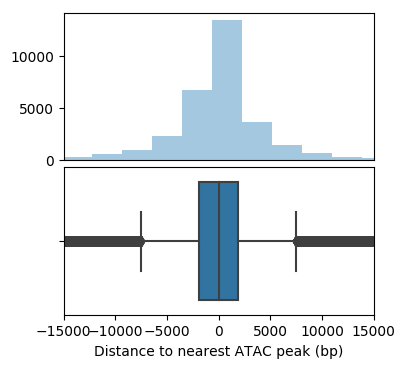

In [189]:
f, ax = plt.subplots(2,1, figsize=(4,4), dpi=100, sharex=True)
sns.distplot(dist_l['itemRgb'], kde=False, bins=3000, ax=ax[0])
sns.boxplot(x=dist_l['itemRgb'], ax=ax[1])
[x.set_xlim(-15000,15000) for x in ax]
ax[0].get_xaxis().set_visible(False)
ax[1].set_xlabel('Distance to nearest ATAC peak (bp)')
f.subplots_adjust(hspace=0.05)
# f.tight_layout()

In [190]:
dist_l.itemRgb.quantile((0.1,0.9))

0.1   -5538.2
0.9    5604.4
Name: itemRgb, dtype: float64

What are the numbers of SNPs per-gene? WHich genes have the largest numbers of SNPs?

In [193]:
filtered_linkage = pd.read_table("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/all_interactions_with_snp.tab")

In [194]:
filtered_linkage.shape

(2892, 37)

In [195]:
snp_info = pd.read_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ld_expansion/ensembl_ldlink_final_snp_info.tab", 
                       sep="\t").drop(columns=['location', 'synonyms', 'chrom', 'start', 'end'])

In [196]:
snp_info_cols = snp_info.columns.tolist()

In [197]:
snp_info_cols[0] = "lead_snp"
snp_info.columns = snp_info_cols

In [198]:
snp_info.drop_duplicates(subset=['lead_snp', 'result'])

,lead_snp,query,r2,result,MAF,allele_string,consequence,minor_allele,snp_id
0,0.967028,rs73414214,0.877796,rs200647091,0.09325,TCTATC/TC,intergenic_variant,-,rs200647091
1,0.967028,rs73414214,0.877796,rs75667371,0.09325,G/A/T,regulatory_region_variant,T,rs75667371
2,0.978042,rs73414214,0.897905,rs17152585,0.09225,T/C,intron_variant,C,rs17152585
3,1.000000,rs73414214,0.828337,rs16872046,0.08307,C/T,intergenic_variant,T,rs16872046
4,0.987727,rs73414214,0.817810,rs144484416,0.08227,C/A,intergenic_variant,A,rs144484416
5,0.945516,rs73414214,0.848263,rs73416225,0.09405,G/A,intergenic_variant,A,rs73416225
6,0.956459,rs73414214,0.868012,rs3757490,0.09325,G/C,regulatory_region_variant,C,rs3757490
7,0.967028,rs73414214,0.877796,rs4140808,0.09305,C/A/G,intergenic_variant,A,rs4140808
8,0.965845,rs73414214,0.917285,rs176485,0.18850,T/A/C,intron_variant,C,rs176485
9,0.978042,rs73414214,0.897905,rs112469266,0.08606,G/A/C,stop_gained,C,rs112469266


In [199]:
filter_w_info = filtered_linkage.merge(snp_info, 
                                       left_on="name_snp", 
                                       right_on="result").drop(columns=['result', 'snp_id', 'score_gene', 'score'])

In [200]:
filter_w_info.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/all_interactions_with_snp_info.tab", sep="\t", index=None)

In [201]:
# Get sorted list of genes with largest number of SNPs, removing duplicate gene-snp records
sorted_gene_by_n_snp = filtered_linkage.drop_duplicates(['name_gene', 'name_snp']).groupby('name_gene').size().sort_values(ascending=False)

In [202]:
filtered_linkage['th1_max_rpkm'] = filtered_linkage.loc[:,['Th1_cytokine_capture', 'Th1_standard']].max(axis=1)
filtered_linkage['th17_max_rpkm'] = filtered_linkage.loc[:,['Th17_cytokine_capture', 'Th17_standard']].max(axis=1)

In [203]:
# Produce a pivot table sorted by number of SNPs per gene
linkage_pivot_genes = filtered_linkage.pivot_table(index=['name_gene'], aggfunc={'name_snp' : lambda x: ';'.join(x),
                                                                                         'gene_symbol' : lambda x: np.unique(x),
                                                                                       'th1_max_rpkm' : max,
                                                                                       'th17_max_rpkm' : max,
                                                                                       'logFC_MSvControl' : np.mean,
                                                                                       'FDR_MSvControl' : np.mean})
linkage_pivot_genes = linkage_pivot_genes.iloc[linkage_pivot_genes.index.get_level_values(level=0).reindex(sorted_gene_by_n_snp.index)[1]]

In [204]:
linkage_pivot_genes['n_snps'] = linkage_pivot_genes['name_snp'].str.split(';').apply(lambda x: len(np.unique(x)))

In [205]:
sorted_gene_by_n_snp

name_gene
ENSG00000038532.16    20
ENSG00000186174.12    19
ENSG00000110375.3     18
ENSG00000264211.1     18
ENSG00000178209.15    17
ENSG00000054523.17    16
ENSG00000204475.10    15
ENSG00000276410.3     15
ENSG00000227507.2     15
ENSG00000204482.10    15
ENSG00000278463.1     15
ENSG00000278705.1     15
ENSG00000287080.1     15
ENSG00000234816.2     15
ENSG00000286522.1     15
ENSG00000232810.4     15
ENSG00000042832.12    14
ENSG00000109332.20    14
ENSG00000155926.14    14
ENSG00000171522.6     13
ENSG00000287736.1     13
ENSG00000113638.14    13
ENSG00000206503.13    12
ENSG00000227766.1     12
ENSG00000164038.16    12
ENSG00000082074.18    12
ENSG00000170776.21    11
ENSG00000255422.3     11
ENSG00000244040.7     11
ENSG00000248710.1     10
                      ..
ENSG00000178741.12     1
ENSG00000179151.13     1
ENSG00000179165.11     1
ENSG00000179335.18     1
ENSG00000179958.9      1
ENSG00000180035.13     1
ENSG00000181220.17     1
ENSG00000182866.17     1
ENSG00000183696

In [206]:
[print(x.split(".")[0]) for x in linkage_pivot_genes.gene_symbol]

CLEC16A
BCL9L
UPK2
MIR4492
PLEC
KIF1B
NCR3
H2BC3
LTB
LST1
H2AC4
H4C2
H3C3
H2AC5P
H3C2
TNF
TG
UBE2D3
SLA
PTGER4
AF305872
TTC33
HLA-A
AL671277
SLC9B2
FYB1
AKAP13
AP002954
IL12A-AS1
AC079594
BDH2
SMC4
PVT1
SLC9B1
IFT80
MIR16-2
MIR15B
AC025171
RMI2
CCDC12
AC025171
AC008875
PPM1L
ITK
ELMO1
NDFIP1
SATB1-AS1
ZNHIT6
RGS14
AC099489
AC009121
AL356234
KCNA2
UBE2D3-AS1
CISD2
AL078459
FASTKD3
C5orf49
ZC3HAV1
HNRNPCP4
AC025682
TENT4A
DIPK1A
GNPDA1
NPEPPS
ASAP1
MTRR
IFNGR2
MAPK1
ASB2
STAT4
DDX6
PTPRC
NDUFAF6
AL356417
IL2RA
TRAF3
RPL5
HLA-DRB5
AL356417
HLA-DRB1
PLEK
ZBTB38
AL035530
AC010609
AL035530
NEUROG2
LZTFL1
CD84
PTPN21
MED10
HLA-F
IKZF3
MEF2B
SP140
GATA3
ZNF683
AL162171
NEUROG2-AS1
SLC9A9
TNIP3
AC099782
AL021154
E2F2
NFKB1
WWOX
AL138930
MERTK
AC067945
MB21D2
TNFAIP8
BORCS8-MEF2B
ZC3H14
ZMIZ1
TAGAP
BCL10
FAM167A
INTS8
AL512306
RPL22L1
TBC1D5
GRK2
SARAF
TGFBR2
AL109767
ZMYND10-AS1
RSPH3
ANKRD13D
AC092718
FAM71B
DLEU1
DYNLRB2
AL138720
AC105411
THG1L
S1PR1
AC108097
WDR82
BX470102
SMLR1
PPM1M
SAMD3


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [207]:
linkage_pivot_genes.to_excel("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/atac_snp_loop/linkage_pivot_genes.xlsx")

In [208]:
sorted_snp_by_n_gene = filtered_linkage.drop_duplicates(['name_gene', 'name_snp']).groupby('name_snp').size().sort_values(ascending=False)
linkage_pivot_snps = filtered_linkage.pivot_table(index=['name_snp', 'name_gene'], aggfunc={'gene_symbol' : lambda x: np.unique(x),
                                                                                       'th1_max_rpkm' : max,
                                                                                       'th17_max_rpkm' : max,
                                                                                       'logFC_MSvControl' : np.mean,
                                                                                       'FDR_MSvControl' : np.mean,
                                                                                           'is_looped' : np.mean})
linkage_pivot_snps = linkage_pivot_snps.iloc[linkage_pivot_snps.index.get_level_values(level=0).reindex(sorted_snp_by_n_gene.index)[1]]

In [209]:
linkage_pivot_snps.to_excel('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/atac_snp_loop/linkage_pivot_snps.xlsx')

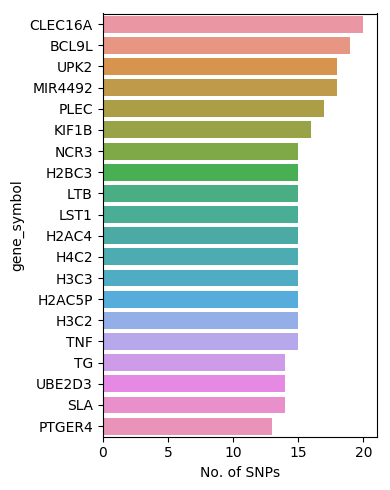

In [210]:
f, ax = plt.subplots(1,1,figsize=(4,5), dpi=100)
sns.barplot(data=linkage_pivot_genes[:20], y='gene_symbol', x="n_snps", ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("No. of SNPs")
f.tight_layout()

In [211]:
filter_w_info.query("gene_symbol == 'PLEC'")['name_snp'].unique()

array(['rs62522555', 'rs11993233', 'rs72693398', 'rs11782331',
       'rs11783799', 'rs6989119', 'rs11136337', 'rs11783772', 'rs6988767',
       'rs11784417', 'rs6993938', 'rs56034811', 'rs7832643', 'rs62523994',
       'rs11778018', 'rs56401356', 'rs55786556'], dtype=object)

In [212]:
filtered_nodup = filtered_linkage[['name_gene', 'name_snp', 'is_looped', 'is_lead_snp', 'gene_symbol']].drop_duplicates()

In [213]:
linkage_pivot_genes

,FDR_MSvControl,gene_symbol,logFC_MSvControl,name_snp,th17_max_rpkm,th1_max_rpkm,n_snps
name_gene,,,,,,,
ENSG00000038532.16,0.736234,CLEC16A,-0.065227,rs12927355;rs3862468;rs3893660;rs3893661;rs719...,5.047638,6.039328,20
ENSG00000186174.12,0.107342,BCL9L,-0.340666,rs4938530;rs12798453;rs4938529;rs527475;rs5850...,13.209772,7.013075,19
ENSG00000110375.3,NaN,UPK2,NaN,rs4938530;rs12798453;rs4938529;rs527475;rs5850...,NaN,NaN,18
ENSG00000264211.1,NaN,MIR4492,NaN,rs4938530;rs12798453;rs4938529;rs527475;rs5850...,NaN,NaN,18
ENSG00000178209.15,0.112730,PLEC,-0.481977,rs62522555;rs11993233;rs72693398;rs11782331;rs...,79.628506,36.212497,17
ENSG00000054523.17,0.098523,KIF1B,0.259137,rs11576384;rs34918542;rs2027332;rs2027331;rs10...,6.071743,11.344733,16
ENSG00000204475.10,0.081482,NCR3,-0.755335,rs9271159;rs9271161;rs9271147;rs9271155;rs9271...,19.565316,6.142695,15
ENSG00000276410.3,NaN,H2BC3,NaN,rs9271159;rs9271161;rs9271147;rs9271155;rs9271...,NaN,NaN,15
ENSG00000227507.2,0.004793,LTB,-0.771065,rs9271159;rs9271161;rs9271147;rs9271155;rs9271...,1052.732148,264.943496,15


In [215]:
most_total_snps = linkage_pivot_genes.iloc[:20, 1].tolist()

In [216]:
most_total_snps

['CLEC16A',
 'BCL9L',
 'UPK2',
 'MIR4492',
 'PLEC',
 'KIF1B',
 'NCR3',
 'H2BC3',
 'LTB',
 'LST1',
 'H2AC4',
 'H4C2',
 'H3C3',
 'H2AC5P',
 'H3C2',
 'TNF',
 'TG',
 'UBE2D3',
 'SLA',
 'PTGER4']

In [217]:
pre_plot = filtered_nodup[filtered_nodup['gene_symbol'].isin(most_total_snps)]
pre_plot['gene_symbol'] = pd.Categorical(pre_plot['gene_symbol'], most_total_snps)
snp_no_plotting = pre_plot.drop_duplicates(['name_snp','name_gene']).groupby(['gene_symbol','is_looped']).agg({'name_snp' : lambda x: len(np.unique(x))}).sort_values('gene_symbol', ascending=False)

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [218]:
snp_no_plotting.sort_values('gene_symbol').reset_index()

,gene_symbol,is_looped,name_snp
0,CLEC16A,False,16
1,CLEC16A,True,4
2,BCL9L,False,1
3,BCL9L,True,18
4,UPK2,True,18
5,MIR4492,True,18
6,PLEC,False,17
7,KIF1B,False,14
8,KIF1B,True,2
9,NCR3,True,15


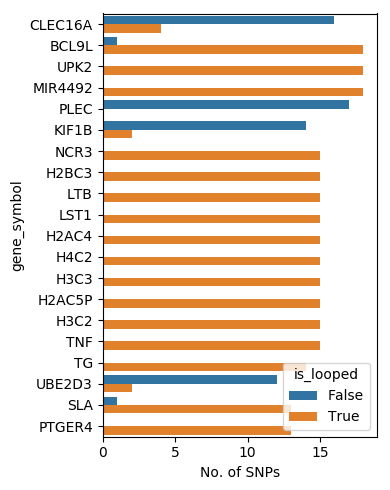

In [219]:
f, ax = plt.subplots(1,1,figsize=(4,5), dpi=100)
sns.barplot(data=snp_no_plotting.sort_values('gene_symbol').reset_index(), y='gene_symbol', x='name_snp', hue='is_looped', ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("No. of SNPs")
f.tight_layout()

In [220]:
filtered_nodup

,name_gene,name_snp,is_looped,is_lead_snp,gene_symbol
0,ENSG00000162585.17,rs554599679,True,False,FAAP20
1,ENSG00000162585.17,rs60733400,True,True,FAAP20
2,ENSG00000202415.1,rs11576384,True,False,RN7SKP269
3,ENSG00000202415.1,rs34918542,True,False,RN7SKP269
4,ENSG00000162441.12,rs11576384,True,False,LZIC
5,ENSG00000162441.12,rs34918542,True,False,LZIC
6,ENSG00000228150.1,rs11576384,True,False,AL357140.2
7,ENSG00000228150.1,rs34918542,True,False,AL357140.2
8,ENSG00000173614.14,rs11576384,True,False,NMNAT1
9,ENSG00000173614.14,rs34918542,True,False,NMNAT1


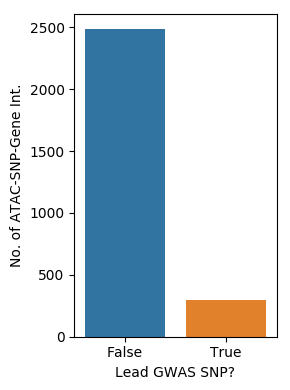

In [221]:
f, ax = plt.subplots(1,1,figsize=(3,4), dpi=100)
sns.countplot(data=filtered_nodup, x='is_lead_snp', ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("No. of ATAC-SNP-Gene Int.")
ax.set_xlabel("Lead GWAS SNP?")
f.tight_layout()

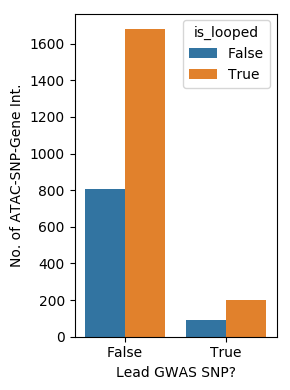

In [222]:
f, ax = plt.subplots(1,1,figsize=(3,4), dpi=100)
sns.countplot(data=filtered_nodup, x='is_lead_snp',  hue="is_looped", ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("No. of ATAC-SNP-Gene Int.")
ax.set_xlabel("Lead GWAS SNP?")
f.tight_layout()

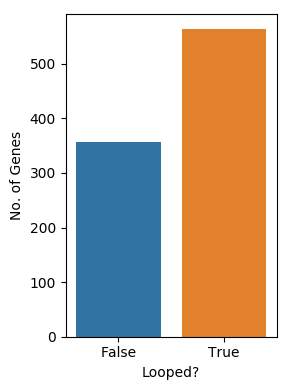

In [223]:
f, ax = plt.subplots(1,1,figsize=(3,4), dpi=100)
sns.countplot(data=filtered_nodup[['gene_symbol', 'is_looped']].sort_values('is_looped', ascending=True).drop_duplicates(['gene_symbol']), x='is_looped', ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("No. of Genes")
ax.set_xlabel("Looped?")
f.tight_layout()

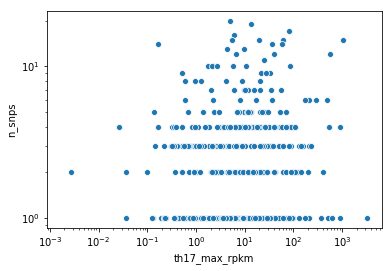

In [224]:
sns.scatterplot(data=linkage_pivot_genes, x='th17_max_rpkm', y='n_snps')
plt.xscale('log')
plt.yscale('log')

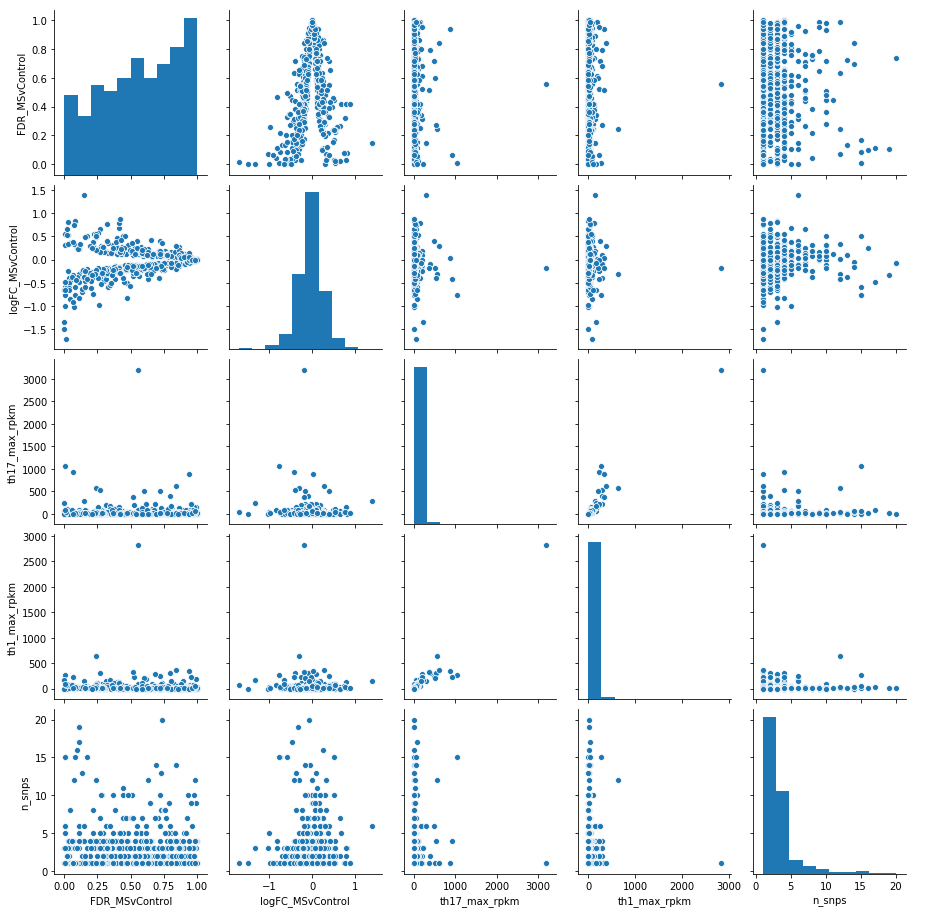

In [225]:
sns.pairplot(data=linkage_pivot_genes[['FDR_MSvControl', 'logFC_MSvControl', 'th17_max_rpkm', 'th1_max_rpkm', 'n_snps']])

In [226]:
linkage_pivot_genes[linkage_pivot_genes['FDR_MSvControl'] < 0.05]

,FDR_MSvControl,gene_symbol,logFC_MSvControl,name_snp,th17_max_rpkm,th1_max_rpkm,n_snps
name_gene,,,,,,,
ENSG00000227507.2,4.793113e-03,LTB,-0.771065,rs9271159;rs9271161;rs9271147;rs9271155;rs9271...,1052.732148,264.943496,15
ENSG00000204482.10,6.964738e-03,LST1,-0.596490,rs9271159;rs9271161;rs9271147;rs9271155;rs9271...,5.377397,3.199796,15
ENSG00000169220.18,4.154557e-02,RGS14,-0.368710,rs4976689;rs4075959;rs4976688;rs4075958;rs6711...,20.938332,11.177276,8
ENSG00000177311.11,2.949754e-03,ZBTB38,0.306912,rs724016;rs2871960;rs13066993;rs13091182;rs199...,7.892550,4.382697,6
ENSG00000180611.7,3.845006e-03,MB21D2,-0.995608,rs9866257;rs12638862;rs34656828;rs2293607;rs38...,29.574038,21.925709,5
ENSG00000166446.15,4.478408e-02,CDYL2,0.352788,rs7188272;rs6564681;rs1019527;rs386965;rs71882...,14.842886,14.080528,4
ENSG00000127152.18,2.582503e-02,BCL11B,-0.256926,rs8003237;rs8023164;rs2015407;rs66552230,29.644164,17.509522,4
ENSG00000184588.18,3.200546e-02,PDE4B,-0.404056,rs575056;rs575056;rs498393;rs524770;rs498448,4.731471,8.875524,4
ENSG00000160888.7,4.367191e-02,IER2,-0.455803,rs17697965;rs10854116;rs6512104,48.595075,44.767555,3


In [227]:
(lambda x: "hs" if "hg" in x else "mm" if "mm" in x else "NONE")("mg")

'NONE'